# Test Models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib widget

import os
import sys
import pandas as pd
import random
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
from glob import glob
import matplotlib.pyplot as plt
import random
import multiprocessing
from tqdm import tqdm
import seaborn as sns
from IPython.display import display

if os.path.dirname(os.getcwd()) not in sys.path:
    sys.path.append(os.path.dirname(os.getcwd()))
import src.util_functions as utils
import src.models.lstm as lstm
from src.models import linear
from src.ArgoverseDataset import ArgoverseDataset

# Setting Parameters for all models

Parameters like data paths, number of workders, and device are to be used for all models

In [3]:
device='cuda'
train_path='/home/apfriend/ucsd/CURRENT/cse151b/kaggle/data/new_train/new_train'
val_path='/home/apfriend/ucsd/CURRENT/cse151b/kaggle/data/new_val_in/new_val_in'
out_path='/home/apfriend/ucsd/CURRENT/cse151b/kaggle/data/save-data'
fig_path='/home/apfriend/ucsd/CURRENT/cse151b/kaggle/latex/figures/train-loss'
os.makedirs(out_path, exist_ok=True)
os.makedirs(fig_path, exist_ok=True)

num_workers=multiprocessing.cpu_count() #4

### Set up datasets

In [4]:
batch_size=64

train_dataset=ArgoverseDataset(data_path=train_path)
val_dataset=ArgoverseDataset(data_path=val_path)

train_loader=DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=utils.collate_train,
    num_workers=num_workers
)

val_loader=DataLoader(
    dataset=val_dataset,
    batch_size=batch_size, 
    shuffle = False, 
    collate_fn=utils.collate_val, 
    num_workers=num_workers
)

## Linear Models

### Simple Linear Model

First try a simple linear regression model with 1 epoch and an `ema_weight` of 0.5 as a baseline.

In [5]:
num_epochs=1
ema_weight=0.5

save_filename=os.path.join(out_path, "2021.05.23-simple-linear-ema050-epoch01.csv")

linear.train(
    model=linear.simple_model,
    data_loader=train_loader,
    n_epochs=num_epochs,
    filename=save_filename,
    ema_weight=ema_weight,
    device=device,
    verbose=False
)

Epoch 1/1: 100%|██████████| 3218/3218 [03:23<00:00, 15.83it/s]


,epoch,iteration,loss_ema,loss
0,0.0,0.0,728.715454,728.715454
1,0.0,1.0,676.213684,623.711914
2,0.0,2.0,568.962463,461.711243
3,0.0,3.0,481.226929,393.491394
4,0.0,4.0,443.326355,405.425812
...,...,...,...,...
3213,0.0,3213.0,58.752567,58.997963
3214,0.0,3214.0,63.253456,67.754341
3215,0.0,3215.0,64.388763,65.524078
3216,0.0,3216.0,54.105129,43.821495


simple_model(
  (linear): Linear(in_features=4560, out_features=7200, bias=True)
)

### Loss of Baseline Model

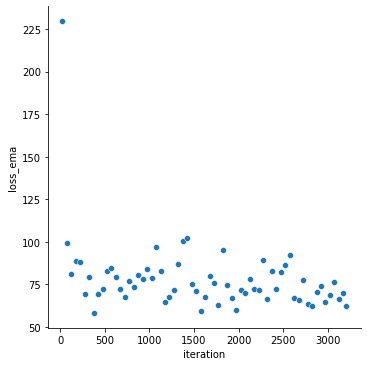

In [6]:
num_iter=50

save_filename=os.path.join(out_path, "2021.05.23-simple-linear-ema050-epoch01.csv")
loss_df1=pd.read_csv(save_filename)
avg_loss1=utils.get_avg_loss(loss_df1,num_iter)

sns.relplot(
    data=avg_loss1,
    x="iteration", 
    y="loss_ema"
);

/media/apfriend/shared/ucsd/classes/cse151b/kaggle/src/util_functions.py:79: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


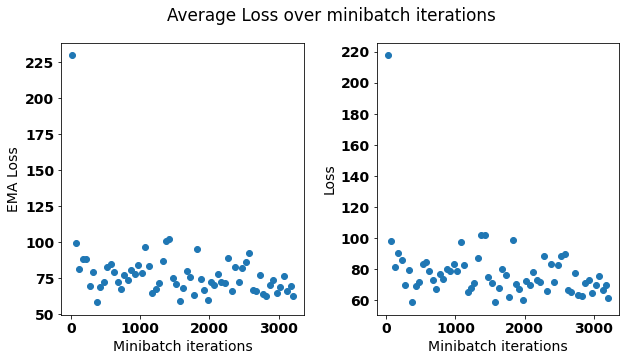

In [7]:
save_path=os.path.join(fig_path, "2021.05.23-simple-linear-ema050-epoch01.pdf")

utils.plot_loss(avg_loss1, save_path)

It appears as though the loss levels out at about 250 iterations through the minibatches.

# Trying a larger batch size

In [4]:
batch_size=128

train_dataset=ArgoverseDataset(data_path=train_path)
val_dataset=ArgoverseDataset(data_path=val_path)

train_loader=DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=utils.collate_train,
    num_workers=num_workers
)

val_loader=DataLoader(
    dataset=val_dataset,
    batch_size=batch_size, 
    shuffle = False, 
    collate_fn=utils.collate_val, 
    num_workers=num_workers
)

In [10]:
num_epochs=1
ema_weight=0.5

save_filename=os.path.join(out_path, "2021.05.23-simple-linear-ema050-epoch01-batchsz128.csv")

lm2=linear.train(
    model=linear.simple_model,
    data_loader=train_loader,
    n_epochs=num_epochs,
    filename=save_filename,
    ema_weight=ema_weight,
    device=device,
    verbose=False
)

Epoch 1/1: 100%|██████████| 1609/1609 [03:04<00:00,  8.70it/s]


,epoch,iteration,loss_ema,loss
0,0.0,0.0,662.466370,662.466370
1,0.0,1.0,625.486206,588.506042
2,0.0,2.0,542.421692,459.357178
3,0.0,3.0,498.511444,454.601196
4,0.0,4.0,481.794434,465.077423
...,...,...,...,...
1604,0.0,1604.0,61.164967,55.203773
1605,0.0,1605.0,54.370995,47.577026
1606,0.0,1606.0,50.519707,46.668423
1607,0.0,1607.0,47.481438,44.443169


In [11]:
loss_df2=pd.read_csv(os.path.join(out_path, "2021.05.23-simple-linear-ema050-epoch01-batchsz128.csv"))

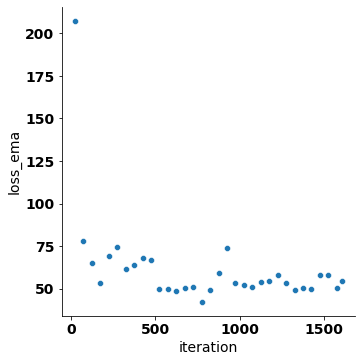

In [12]:
num_iter=50

avg_loss2=utils.get_avg_loss(loss_df2, num_iter)
sns.relplot(
    data=avg_loss2,
    x="iteration", 
    y="loss_ema"
);

In [13]:
save_path=os.path.join(fig_path, "2021.05.23-simple-linear-ema050-epoch01-batchsz128.pdf")

utils.plot_loss(avg_loss2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

It would appear as though a larger batch size helped the model lower its loss more quickly

## Next lets try adjusting ema_weight

In [14]:
num_epochs=1
ema_weight=0.75

save_filename=os.path.join(out_path, "2021.05.23-simple-linear-ema075-epoch01-batchsz128.csv")

lm3=linear.train(
    model=linear.simple_model,
    data_loader=train_loader,
    n_epochs=num_epochs,
    filename=save_filename,
    ema_weight=ema_weight,
    device=device,
    verbose=False
)
loss_df3=pd.read_csv(save_filename)

Epoch 1/1: 100%|██████████| 1609/1609 [03:08<00:00,  8.54it/s]


,epoch,iteration,loss_ema,loss
0,0.0,0.0,687.733582,687.733582
1,0.0,1.0,667.989746,608.758179
2,0.0,2.0,619.537292,474.180023
3,0.0,3.0,567.503418,411.401917
4,0.0,4.0,534.929810,437.208893
...,...,...,...,...
1604,0.0,1604.0,66.209267,62.209248
1605,0.0,1605.0,69.408798,79.007385
1606,0.0,1606.0,74.222908,88.665245
1607,0.0,1607.0,72.777252,68.440285


In [15]:
%matplotlib widget

save_path=os.path.join(fig_path, "2021.05.23-simple-linear-ema075-epoch01-batchsz128.pdf")
num_iter=50

avg_loss3=utils.get_avg_loss(loss_df3, num_iter)
utils.plot_loss(avg_loss3, save_path)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [16]:
#save model
save_path='/home/apfriend/ucsd/CURRENT/cse151b/kaggle/trained-models'
lm3_name='lm3.pth'
fn=os.path.join(save_path, lm3_name)
torch.save(lm3.state_dict(), fn)

### Load model

In [324]:
help(lm3.load_state_dict)

Help on function load_state_dict in module torch.nn.modules.module:

load_state_dict(self, state_dict: 'OrderedDict[str, Tensor]', strict: bool = True)
    Copies parameters and buffers from :attr:`state_dict` into
    this module and its descendants. If :attr:`strict` is ``True``, then
    the keys of :attr:`state_dict` must exactly match the keys returned
    by this module's :meth:`~torch.nn.Module.state_dict` function.
    
    Args:
        state_dict (dict): a dict containing parameters and
            persistent buffers.
        strict (bool, optional): whether to strictly enforce that the keys
            in :attr:`state_dict` match the keys returned by this module's
            :meth:`~torch.nn.Module.state_dict` function. Default: ``True``
    
    Returns:
        ``NamedTuple`` with ``missing_keys`` and ``unexpected_keys`` fields:
            * **missing_keys** is a list of str containing the missing keys
            * **unexpected_keys** is a list of str containing the une

In [327]:
torch.load(lm3_path)

OrderedDict([('linear.weight',
              tensor([[ 0.0353,  0.0107,  0.0691,  ..., -0.0131,  0.0109, -0.0143],
                      [-0.0015,  0.0219, -0.0069,  ..., -0.0036, -0.0105, -0.0052],
                      [ 0.0008, -0.0157,  0.0595,  ...,  0.0020, -0.0018, -0.0081],
                      ...,
                      [ 0.0061,  0.0087, -0.0025,  ..., -0.0087,  0.0033, -0.0083],
                      [-0.0012,  0.0131,  0.0120,  ...,  0.0067, -0.0018, -0.0018],
                      [ 0.0117, -0.0018, -0.0076,  ...,  0.0127, -0.0009, -0.0099]],
                     device='cuda:0')),
             ('linear.bias',
              tensor([ 0.0216,  0.0116,  0.0094,  ..., -0.0010,  0.0120, -0.0137],
                     device='cuda:0'))])

In [333]:
lm3_path=os.path.join(save_path, "lm3.pth")
# lm3_state_dict=torch.load(lm3_path)
lm3=linear.simple_model(device)
lm3.load_state_dict(torch.load(lm3_path))
lm3.to(device)

simple_model(
  (linear): Linear(in_features=4560, out_features=7200, bias=True)
)

In [334]:
scene_idxs, out_data=utils.run_trained_model(
    model=lm3,
    dataset=val_dataset,
    batch_size=128,
    device=device
)

100%|██████████| 25/25 [00:02<00:00, 11.73it/s]


In [337]:
lm3_df=utils.get_trained_data(
    model=lm3,
    dataset=val_dataset,
    batch_size=128,
    device=device
)
lm3_df.head()

100%|██████████| 25/25 [00:02<00:00, 11.89it/s]


,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60
0,10002,1722.683594,326.232697,1722.786865,337.753754,1734.137085,346.954590,1702.998169,347.886139,1739.039673,...,1726.064087,360.986664,1763.540039,366.504120,1738.249146,370.030212,1759.909058,349.761536,1742.953613,379.619263
1,10015,733.598450,1274.009033,690.256287,1235.183350,726.327393,1230.683228,737.839294,1213.237061,728.862061,...,724.621826,1222.023315,720.734070,1218.781616,760.155762,1211.066895,719.192810,1226.144043,724.991821,1207.510132
2,10019,575.424194,1251.069092,571.312500,1245.371704,605.294617,1230.286377,584.504822,1237.744507,574.583069,...,580.744019,1240.999268,593.565430,1226.737305,590.139954,1261.766235,575.736511,1255.562866,571.146973,1255.722412
3,10028,1699.449707,321.985504,1688.885376,298.228485,1685.443115,299.619446,1720.546387,304.189667,1710.106812,...,1662.923950,309.165070,1711.859863,316.625000,1721.195801,312.510193,1689.033691,326.636932,1716.564453,366.634521
4,1003,2093.113037,666.160339,2125.383545,676.679565,2107.488525,684.188965,2147.130859,683.643921,2122.042725,...,2077.792236,655.861511,2099.793213,633.579285,2085.367188,682.018188,2094.463623,661.763916,2057.687012,649.626831


In [338]:
lm3_df.to_csv("submit.csv", index=False)

## Lets try training for more epochs

Will use conv

In [5]:
num_epochs=10
ema_weight=0.75

save_filename=os.path.join(out_path, "2021.05.24-simple-linear-ema075-epoch10-batchsz128.csv")

lm4=linear.train(
    model=linear.simple_model,
    data_loader=train_loader,
    n_epochs=num_epochs,
    filename=save_filename,
    ema_weight=ema_weight,
    device=device,
    verbose=False
)

loss_df4=pd.read_csv(save_filename)

# save_path=os.path.join(fig_path, "2021.05.23-simple-linear-ema075-epoch01-batchsz128-2.pdf")
num_iter=50

avg_loss4=utils.get_avg_loss(loss_df4, num_iter)
utils.plot_loss(avg_loss4, save_path)

lm4_df=utils.get_trained_data(
    model=lm3,
    dataset=val_dataset,
    batch_size=128,
    device=device
)
lm4_df.head()

Epoch 1/10:  32%|███▏      | 508/1609 [00:58<02:06,  8.72it/s]


KeyboardInterrupt: 

In [ ]:
lm4_df.to_csv("submit4.csv", index=False)

In [11]:
%matplotlib widget



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Multi linear model

In [20]:
num_epochs=1
ema_weight=0.75

save_filename=os.path.join(out_path, "2021.05.24-multi-linear-ema075-epoch01-batchsz128.csv")

lm5=linear.train(
    model=linear.multilayer_model,
    data_loader=train_loader,
    n_epochs=num_epochs,
    filename=save_filename,
    ema_weight=ema_weight,
    device=device,
    verbose=False
)

loss_df5=pd.read_csv(save_filename)

save_path=os.path.join(fig_path, "2021.05.24-multi-linear-ema075-epoch01-batchsz128.pdf")
num_iter=50

avg_loss5=utils.get_avg_loss(loss_df5, num_iter)
utils.plot_loss(avg_loss5, save_path)

lm5_df=utils.get_trained_data(
    model=lm5,
    dataset=val_dataset,
    batch_size=128,
    device=device
)
lm5_df.head()

Epoch 1/1: 100%|██████████| 1609/1609 [03:16<00:00,  8.18it/s]


,epoch,iteration,loss_ema,loss
0,0.0,0.0,632.725708,632.725708
1,0.0,1.0,843.409790,1475.461914
2,0.0,2.0,736.740967,416.734283
3,0.0,3.0,676.144592,494.355469
4,0.0,4.0,628.185791,484.309235
...,...,...,...,...
1604,0.0,1604.0,16.069969,19.197361
1605,0.0,1605.0,15.824123,15.086585
1606,0.0,1606.0,15.684133,15.264161
1607,0.0,1607.0,14.933064,12.679859


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

100%|██████████| 25/25 [00:02<00:00, 12.25it/s]


,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60
0,10002,1690.839111,395.199738,1690.789917,402.042053,1696.886719,403.853638,1695.063599,402.265411,1697.819946,...,1705.398315,409.313751,1707.321411,406.663269,1697.627319,410.265076,1706.594238,412.399628,1698.345337,407.370026
1,10015,717.963257,1250.626343,721.894714,1250.263916,720.546387,1249.975464,719.464783,1252.650513,719.854492,...,721.921082,1250.708618,725.473145,1249.554199,723.258850,1252.422852,725.197571,1248.516479,720.762573,1251.798096
2,10019,578.972534,1274.507568,578.984497,1274.866699,578.137268,1273.432495,582.364929,1275.058228,581.989441,...,576.208862,1265.538452,578.717346,1266.477661,577.582581,1270.038818,576.657104,1269.014160,576.221924,1268.972168
3,10028,1687.774536,340.027252,1689.244019,336.135925,1684.614380,344.093842,1681.611572,343.674530,1682.822266,...,1685.286987,342.638824,1688.360596,357.336334,1684.591553,348.264557,1685.016235,346.984894,1686.861328,348.618256
4,1003,2095.923096,678.379211,2095.605713,685.103821,2095.122314,682.988892,2095.929443,687.045837,2094.464600,...,2096.358398,681.797852,2097.010254,679.578552,2101.491455,672.180786,2096.854980,679.825684,2098.236084,679.582092


In [21]:
lm5_df.to_csv("submit5.csv", index=False)

In [5]:
num_epochs=10
ema_weight=0.75

save_filename=os.path.join(out_path, "2021.05.24-multi-linear-ema075-epoch10-batchsz128.csv")

lm6=linear.train(
    model=linear.multilayer_model,
    data_loader=train_loader,
    n_epochs=num_epochs,
    filename=save_filename,
    ema_weight=ema_weight,
    device=device,
    verbose=False
)

loss_df6=pd.read_csv(save_filename)

save_path=os.path.join(fig_path, "2021.05.24-multi-linear-ema075-epoch10-batchsz128.pdf")
num_iter=50

avg_loss6=utils.get_avg_loss(loss_df6, num_iter)
utils.plot_loss(avg_loss5, save_path)

lm_df6=utils.get_trained_data(
    model=lm6,
    dataset=val_dataset,
    batch_size=128,
    device=device
)
lm6_df.head()

Epoch 10/10: 100%|██████████| 1609/1609 [03:29<00:00,  7.70it/s]


""


EmptyDataError: No columns to parse from file

In [23]:
lm_df6.to_csv("submit6.csv", index=False)

In [35]:
loss_data=pd.read_csv(os.path.join(out_path, "2021.05.24-multi-linear-ema075-epoch10-batchsz128.csv"))

epoch_avg=loss_data.groupby(["epoch"])[["loss_ema","loss"]].mean()

save_path=os.path.join(fig_path, "2021.05.24-multi-linear-ema075-epoch10-batchsz128-epoch-avg.pdf")
utils.plot_avg_epoch_loss(epoch_avg, save_path)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [29]:
avg_loss6=utils.get_avg_loss(loss_df6, num_iter)
utils.plot_loss(avg_loss6, save_path)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …